### Authors : Kanvaly FADIGA & Mohamed TRAORE

In [1]:
# execute this part to modify the css style
from IPython.core.display import HTML
def css_styling():
    styles = open("data/custom3.css").read()
    return HTML(styles)
css_styling()

# Credit Default Prediction - Imbalance Data -> Balanced Data 

In this notebook we will evaluate the impact of data sampling methods on prediction of credit default classifier. The goal at the end his to choose of these methods as our sampling algorithm 

We will explore two sampling methods:
* Undersapling (Random and NearMiss)
* Oversampling (Random and SMOTE)

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/resampling.png)

In [10]:
import warnings
warnings.filterwarnings("ignore")

from Models.model_training import * 
from Models.model_tuning import * 
from FeaturesEngineering.preprocessing import *
from utils.sampling import *
from utils.util import *
from FeaturesEngineering.encoding import *

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd
import pandas_profiling as pp


df = prepocess_data("data/raw/CreditTraining.csv")

#encode data
cat = [col for col in df if df[col].dtype.name == 'category'] + ['is_closed_date']
dict_encod = {"WOEEncoder": cat}
encoder = encoding(dict_encod)
encoder.fit(df,df.Y)
df = encoder.transform(df)

X = df.drop("Y", axis=1)
y = df.Y
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)

Memory usage of dataframe is 0.82 MB
Memory usage after optimization is: 0.18 MB
Decreased by 78.6%


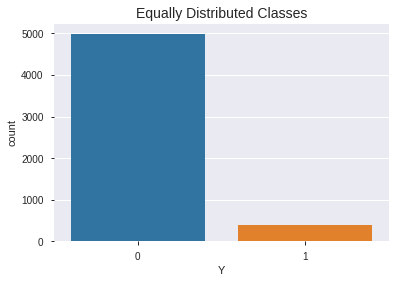

In [11]:
sns.countplot('Y', data=df)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

## Random Under-Sampling


Random under-sampling:
1    314
0    314
Name: Y, dtype: int64


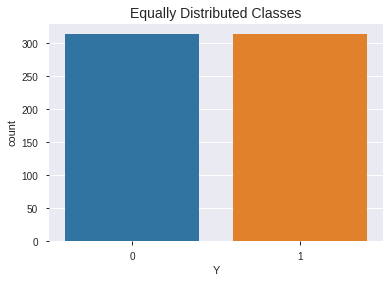

In [12]:
#* under sampling
df_under = X_train.assign(Y=y_train.values)
df_under = random_under_sampling(df_under)

#plot
sns.countplot('Y', data=df_under)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

### Classifier selection

In [13]:
clf_list = ["LogisticRegression",
            "XGBClassifier",
            "RandomForestClassifier", 
            "MLPClassifier",
            "AdaBoostClassifier",
            "LGBMClassifier",
            "KNeighborsClassifier",
            "SVC",
            "GaussianProcessClassifier",
            "DecisionTreeClassifier",
           ]

classifiers = get_models(clf_list, 
                         X_train, 
                         y_train,
                         sampling_method=RandomUnderSampler(sampling_strategy='majority')
                        )

### Training

In [14]:
classifiers, result = train_models(classifiers=classifiers, X=X_train, y=y_train)

0/10 : Training LogisticRegression .... [OK]
1/10 : Training XGBClassifier .... [OK]
2/10 : Training RandomForestClassifier .... [OK]
3/10 : Training MLPClassifier .... [OK]
4/10 : Training AdaBoostClassifier .... [OK]
5/10 : Training LGBMClassifier .... [OK]
6/10 : Training KNeighborsClassifier .... [OK]
7/10 : Training SVC .... [OK]
8/10 : Training GaussianProcessClassifier .... [OK]
9/10 : Training DecisionTreeClassifier .... [OK]


In [15]:
result

,clf_name,pr,rc,f1,auc,acc
0,LogisticRegression,0.389877,0.907643,0.545455,0.897862,0.889509
1,XGBClassifier,0.378973,0.987261,0.547703,0.929892,0.880903
2,RandomForestClassifier,0.416546,0.914013,0.572283,0.906567,0.900209
3,MLPClassifier,0.363014,0.843949,0.507663,0.863631,0.880437
4,AdaBoostClassifier,0.362264,0.917197,0.519387,0.894985,0.876018
5,LGBMClassifier,0.307364,0.917197,0.460432,0.877168,0.842987
6,KNeighborsClassifier,0.163241,0.859873,0.274390,0.756285,0.667830
7,SVC,0.731132,0.987261,0.840108,0.979327,0.972552
8,GaussianProcessClassifier,0.380826,0.910828,0.537089,0.897070,0.885322
9,DecisionTreeClassifier,0.363190,0.942675,0.524358,0.906218,0.875087


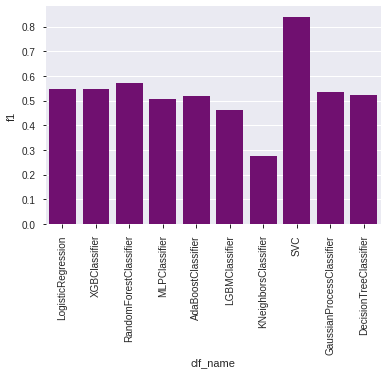

In [16]:
g = sns.barplot(x="clf_name", y="f1", color="purple", data=result)
g.set_xticklabels(labels=g.get_xticklabels(),rotation=90)
plt.show()

### Test

                    clf_name        pr        rc        f1       auc       acc
0         LogisticRegression  0.382857  0.858974  0.529644  0.875325  0.889302
1              XGBClassifier  0.331658  0.846154  0.476534  0.856377  0.865116
2     RandomForestClassifier  0.411392  0.833333  0.550847  0.870027  0.901395
3              MLPClassifier  0.360000  0.807692  0.498024  0.847678  0.881860
4         AdaBoostClassifier  0.349206  0.846154  0.494382  0.861392  0.874419
5             LGBMClassifier  0.304721  0.910256  0.456592  0.873884  0.842791
6       KNeighborsClassifier  0.130926  0.743590  0.222649  0.678716  0.623256
7                        SVC  0.242424  0.102564  0.144144  0.538744  0.911628
8  GaussianProcessClassifier  0.347826  0.820513  0.488550  0.850076  0.875349
9     DecisionTreeClassifier  0.316038  0.858974  0.462069  0.856769  0.854884


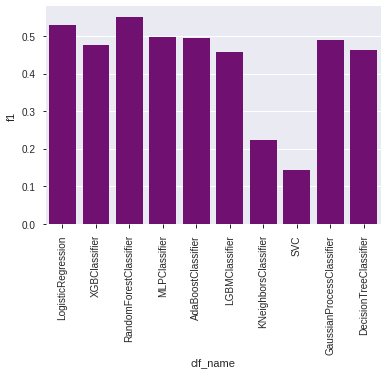

In [18]:
result = pd.DataFrame(columns=["clf_name", "pr", "rc", "f1", "auc", "acc"])
for i, (name, clf) in enumerate(classifiers.items()):
    y_pred = clf.steps[-1][1].predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    pr = precision_score(y_test, y_pred)
    rc = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    result.loc[i] = [name, pr, rc, f1, auc, acc]
    
print(result)
g = sns.barplot(x="clf_name", y="f1", color="purple", data=result)
g.set_xticklabels(labels=g.get_xticklabels(),rotation=90)
plt.show()

**Random Forest Classifier is more accurate than the other three classifiers in most cases. It is followed by Logistic regression and Adaboost**

# Over sampling

Random over-sampling:
1    3985
0    3985
Name: Y, dtype: int64


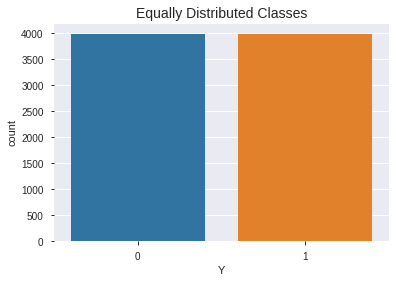

In [29]:
#* under sampling
df_under = X_train.assign(Y=y_train.values)
df_under = random_over_sampling(df_under)

#plot
sns.countplot('Y', data=df_under)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

### Classifier selection

In [31]:
clf_list = ["LogisticRegression",
            "XGBClassifier",
            "RandomForestClassifier", 
            "MLPClassifier",
            "AdaBoostClassifier",
            "LGBMClassifier"
           ]

from imblearn.over_sampling import RandomOverSampler

classifiers = get_models(clf_list, 
                         X_train, 
                         y_train,
                         sampling_method=RandomOverSampler(sampling_strategy='minority')
                        )

In [33]:
classifiers, result = train_models(classifiers=classifiers, X=X_train, y=y_train)

0/6 : Training LogisticRegression .... [OK]
1/6 : Training XGBClassifier .... [OK]
2/6 : Training RandomForestClassifier .... [OK]
3/6 : Training MLPClassifier .... [OK]
4/6 : Training AdaBoostClassifier .... [OK]
5/6 : Training LGBMClassifier .... [OK]


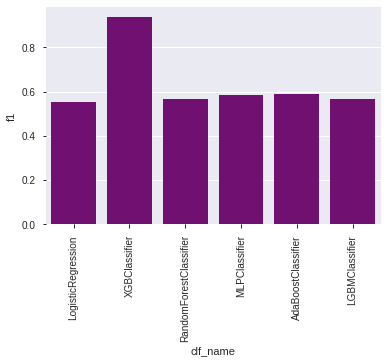

In [36]:
g = sns.barplot(x="clf_name", y="f1", color="purple", data=result)
g.set_xticklabels(labels=g.get_xticklabels(),rotation=90)
plt.show()

                 clf_name        pr        rc        f1       auc       acc
0      LogisticRegression  0.391566  0.833333  0.532787  0.866015  0.893953
1           XGBClassifier  0.370787  0.423077  0.395210  0.683454  0.906047
2  RandomForestClassifier  0.411392  0.833333  0.550847  0.870027  0.901395
3           MLPClassifier  0.391026  0.782051  0.521368  0.843383  0.895814
4      AdaBoostClassifier  0.426667  0.820513  0.561404  0.867127  0.906977
5          LGBMClassifier  0.426752  0.858974  0.570213  0.884352  0.906047


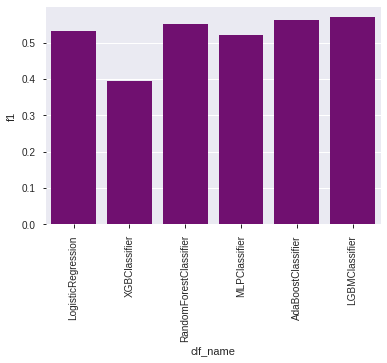

In [37]:
result = pd.DataFrame(columns=["clf_name", "pr", "rc", "f1", "auc", "acc"])
for i, (name, clf) in enumerate(classifiers.items()):
    y_pred = clf.steps[-1][1].predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    pr = precision_score(y_test, y_pred)
    rc = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    result.loc[i] = [name, pr, rc, f1, auc, acc]
    
print(result)
g = sns.barplot(x="clf_name", y="f1", color="purple", data=result)
g.set_xticklabels(labels=g.get_xticklabels(),rotation=90)
plt.show()

# Oversampling SMOTE

![](https://www.marcoaltini.com/uploads/1/3/2/3/13234002/9101820.jpg?372)

Synthetic data are created only for the training set without affecting the validation set.

In [38]:
clf_list = ["LogisticRegression",
            "XGBClassifier",
            "RandomForestClassifier", 
            "MLPClassifier",
            "AdaBoostClassifier",
            "LGBMClassifier"
           ]

from imblearn.over_sampling import SMOTE

classifiers = get_models(clf_list, 
                         X_train, 
                         y_train,
                         sampling_method=SMOTE(sampling_strategy='minority')
                        )

In [39]:
classifiers, result = train_models(classifiers=classifiers, X=X_train, y=y_train)

0/6 : Training LogisticRegression .... [OK]
1/6 : Training XGBClassifier .... [OK]
2/6 : Training RandomForestClassifier .... [OK]
3/6 : Training MLPClassifier .... [OK]
4/6 : Training AdaBoostClassifier .... [OK]
5/6 : Training LGBMClassifier .... [OK]


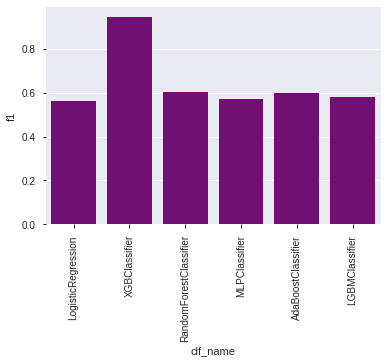

In [40]:
g = sns.barplot(x="clf_name", y="f1", color="purple", data=result)
g.set_xticklabels(labels=g.get_xticklabels(),rotation=90)
plt.show()

                 clf_name        pr        rc        f1       auc       acc
0      LogisticRegression  0.414013  0.833333  0.553191  0.870528  0.902326
1           XGBClassifier  0.479452  0.448718  0.463576  0.705302  0.924651
2  RandomForestClassifier  0.430769  0.717949  0.538462  0.821863  0.910698
3           MLPClassifier  0.388889  0.807692  0.525000  0.854197  0.893953
4      AdaBoostClassifier  0.416058  0.730769  0.530233  0.825264  0.906047
5          LGBMClassifier  0.429530  0.820513  0.563877  0.867629  0.907907


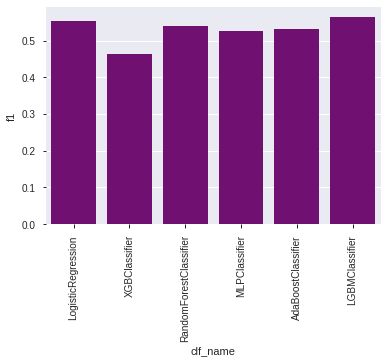

In [41]:
result = pd.DataFrame(columns=["clf_name", "pr", "rc", "f1", "auc", "acc"])
for i, (name, clf) in enumerate(classifiers.items()):
    y_pred = clf.steps[-1][1].predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    pr = precision_score(y_test, y_pred)
    rc = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    result.loc[i] = [name, pr, rc, f1, auc, acc]
    
print(result)
g = sns.barplot(x="clf_name", y="f1", color="purple", data=result)
g.set_xticklabels(labels=g.get_xticklabels(),rotation=90)
plt.show()

# Conclusion

The best sampling method here is random over sampling. So we will use it in the next section 